<a href="https://colab.research.google.com/github/arsyiadlani/NLP-Sentiment-Analysis/blob/main/reddit_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA RETRIEVING

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/Reddit_Data.csv")
df

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


##DATA PREPROCESSING

In [ ]:
# Searching unique values of "category" column to determine model classes
df["category"].unique()

array([ 1, -1,  0])

In [ ]:
# Checking for null values in the dataset
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [ ]:
# Handling null values in the dataset
df.loc[df["clean_comment"].isnull(), "category"] = 0  # Labeling null values of comment as 0 (neutral)
df.fillna(value="not available", inplace=True)

In [ ]:
# Ensuring the null values has been filled
df.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [ ]:
# Determining the algorithm for the neural model
import numpy as np

sample_num = 37249  # Number of samples in the dataset
words_num = []

for sentence in added_df["clean_comment"].values:
  len_words = len(sentence.split())
  words_num.append(len_words)

words_per_sample = np.median(words_num)  # Median value of the number of words in a sample

print(sample_num / words_per_sample)  

"""Because the value of total sample number divided by median of the number of words 
in every sample is >1500, we can safely conclude that this particular dataset is 
suitable for NLP analysis using embedding vectors technique.
"""

2865.3076923076924


In [ ]:
# Labeling the dataset
df["category"].replace({-1:"negative", 0:"neutral", 1:"positive"}, inplace=True)
df

,clean_comment,category
0,family mormon have never tried explain them t...,positive
1,buddhism has very much lot compatible with chr...,positive
2,seriously don say thing first all they won get...,negative
3,what you have learned yours and only yours wha...,neutral
4,for your own benefit you may want read living ...,positive
...,...,...
37244,jesus,neutral
37245,kya bhai pure saal chutiya banaya modi aur jab...,positive
37246,downvote karna tha par upvote hogaya,neutral
37247,haha nice,positive


In [ ]:
# One-hot-encoding the dataset
sentiment_category = pd.get_dummies(df["category"])
added_df = pd.concat([df, sentiment_category], axis=1).drop(columns="category")
added_df = added_df.sample(frac=1).reset_index(drop=True)  # Shuffling the dataset
added_df

,clean_comment,negative,neutral,positive
0,well many people use these words differently y...,0,0,1
1,this does not need controversial especially sc...,0,0,1
2,you don say,0,1,0
3,hindu don eat beef love cattle and see nothin...,0,0,1
4,naseeb wala ass context modi speaking petrol ...,0,1,0
...,...,...,...,...
37244,futuristic battles,0,1,0
37245,pak presiden republik indonesia bapak jokowi d...,0,1,0
37246,modi goverment did this not him alone individu...,0,1,0
37247,friends notes events sabhi recovery kar sakte...,0,1,0


In [ ]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = added_df["clean_comment"].values
y = added_df.iloc[:, 1:4].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Tokenizing the dataset
tokenizer = Tokenizer(num_words=3800, oov_token="oov")
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding the dataset sequences
padded_train = pad_sequences(train_sequences)
padded_test = pad_sequences(test_sequences)

##MODEL TUNING AND STRUCTURING

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Implementing callback
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy") > 0.915) and (logs.get("val_accuracy") > 0.915):
      print("\nModel training & validation process has reached more than 91% of accuracy!")
      self.model.stop_training = True

callbacks = MyCallback()

# Building and structuring the neural model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=3800, output_dim=16),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()  # Reviewing the neural model architecture

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

# Training the neural model
history = model.fit(padded_train, y_train, validation_data=(padded_test, y_test), 
                    epochs=30, callbacks=[callbacks], verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          60800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

##MODEL LOSS AND ACCURACY VISUALIZATION

###LOSS VISUALIZATION

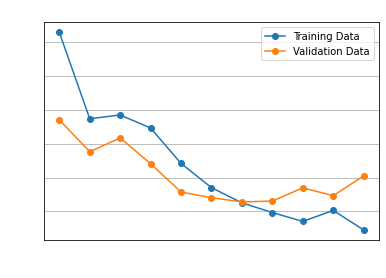

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], marker="o", label="Training Data")
plt.plot(history.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold", color="white")
plt.xlabel("Epoch", color="white")
plt.ylabel("Loss", color="white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

###ACCURACY VISUALIZATION

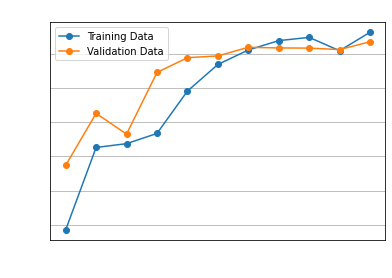

In [ ]:
# Plot training and validation accuracy during learning process
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], marker="o", label="Training Data")
plt.plot(history.history["val_accuracy"], marker="o", label="Validation Data")
plt.title("ACCURACY GRAPH", weight="bold", color="white")
plt.xlabel("Epoch", color="white")
plt.ylabel("Accuracy", color="white")
plt.tick_params(axis="x", colors="white")
plt.tick_params(axis="y", colors="white")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

##REFERENCE

###Dataset source: https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv